In [3]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
'''
this file can single run main function
'''
from numpy.linalg import inv
from numpy import identity
from numpy import matrix, diag, random
import numpy as np
import matplotlib.pyplot as plt
import random

class CVKalmanFilter:
    """
    Simple Kalman filter
    Control term has been omitted for now
    """
    def __init__(self, X, P, F, Q, Z, H, R):
        """
        Initialise the filter
        Args:
            X: State estimate 
            P: Estimate covariance
            F: State transition model
            Q: Process noise covariance
            Z: Measurement of the state X
            H: Observation model
            R: Observation noise covariance
        """
        self.X = X
        self.P = P
        self.F = F
        self.Q = Q
        self.Z = Z
        self.H = H
        self.R = R


    def predict(self, X, P, w=0):
        """
        Predict the future state
        Args:
            X: State estimate
            P: Estimate covariance
            w: Process noise
        Returns:
            updated (X, P)
        """
        # Project the state ahead
        X = np.dot(self.F ,X) + w
        P = np.dot(np.dot(self.F , P) , self.F.T) + self.Q

        return(X, P)

    def update(self, X, P, Z):
        """
        Update the Kalman Filter from a measurement
        Args:
            X: State estimate
            P: Estimate covariance
            Z: State measurement
        Returns:
            updated (X, P)
        """
        S = np.dot(np.dot(self.H, P), self.H.T) + self.R
        K = np.dot(np.dot(P, self.H.T), np.linalg.inv(S))
        
        y = Z - np.dot(self.H, X)
        X = X + np.dot(K, y)
        P = np.dot((identity(P.shape[1]) - np.dot(K, self.H)), P)
        return (X, P)


100 100


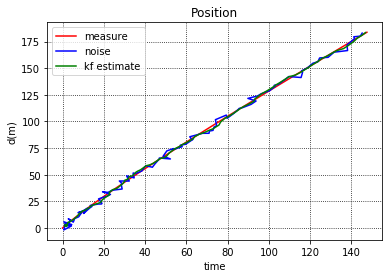

<Figure size 432x288 with 0 Axes>

In [8]:
# data set
# own set,The format is  dataset=[time px py];
dataset=[]
# Time step size
dt = 0.1
# constuct dataset
t=np.arange(0, 10, dt)
v_x=10
v_y=10
a_x=2
a_y=2
theta=np.pi/3
px=v_x*np.cos(theta)*t+0.5*a_x*t*t
py=v_y*np.sin(theta)*t+0.5*a_y*t*t


# add gauss noise
mu = 0
sigma = 1.5
noise_px=np.zeros(np.array(px).shape)
noise_py=np.zeros(np.array(py).shape)
for i in range(len(px)):
    noise_px[i] = px[i] + random.gauss(mu,sigma)
    noise_py[i] = py[i] + random.gauss(mu,sigma)

# plt.plot(px,py,noise_px,noise_py)
# plt.show()

for i in range(len(t)):
    c=[]
    c.append(t[i])
    c.append(noise_px[i])
    c.append(noise_py[i])
    dataset.append(c)

# Standard deviation of random accelerations
sigma_a = 0.2
# Standard deviation of observations
sigma_z = 0.2

# State vector: [[Position_x],[Position_x] [velocity_x]  [velocity_y]
# [acc_x]  [acc_y]]
X = np.zeros(6).reshape(6,1)

# State transition model 6*6
F = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# Initial state covariance 6*6
p_var = 0.1
P = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
P = P * p_var

# Observation vector
Z = np.zeros(2).reshape(2,1)

# Observation model
H = np.array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.]])

# Observation covariance -> size(z.shape[0],z.shape[0])
r_var=0.25
R = np.diag([1.0, 1.0])
R = R * r_var

# Process noise covariance matrix
q_var = 0.01
Q = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
Q = Q * q_var

# Initialise the filter
kf = CVKalmanFilter(X, P, F, Q, Z, H, R)


# initial the first value

pre_time=dataset[0][0]
X[0,0]=dataset[0][1]
X[1,0]=dataset[0][2]

# initial result value
kf_result = []
kf_result.append(X)

# Number of measurement_step
measurement_step = len(dataset)

for i in range(1, measurement_step):
    
    t_measurement = dataset[i]
    delta_ts = (t_measurement[0] - pre_time)
    pre_time = t_measurement[0]
    # print(delta_ts,kf.F)
    kf.F[0, 2] = delta_ts
    kf.F[0, 4] = 0.5 * delta_ts * delta_ts
    kf.F[1, 3] = delta_ts
    kf.F[1, 5] = 0.5 * delta_ts * delta_ts
    kf.F[2, 4] = delta_ts
    kf.F[3, 5] = delta_ts

    # Predict
    (X, P) = kf.predict(X, P)
    # Update
    m_x = t_measurement[1]
    m_y = t_measurement[2]
    Z = np.array([[m_x], [m_y]])
    (X, P) = kf.update(X, P, Z)
    # save the filter position
    kf_result.append(X)

# plot
print(len(kf_result),len(t))
kf_global_x_list = []
kf_global_y_list = []
kf_velocity_x_list = []
kf_velocity_y_list = []
kf_acc_x_list = []
kf_acc_y_list = []

for i in range(len(kf_result)):
    # print kf_result[i], kf_result[i][0],kf_result[i][1]   
    kf_global_x_list.append(kf_result[i][0])
    kf_global_y_list.append(kf_result[i][1])
    kf_velocity_x_list.append(kf_result[i][2])
    kf_velocity_y_list.append(kf_result[i][3])
    kf_acc_x_list.append(kf_result[i][4])
    kf_acc_y_list.append(kf_result[i][5])
    
# 测试
plt.figure()
plt.plot(px,py, 'r-',  label='measure') 
plt.plot(noise_px,noise_py, 'b-',  label='noise') 
plt.plot(kf_global_x_list,kf_global_y_list, 'g-',  label='kf estimate') 
plt.title("Position") 
plt.xlabel("time") 
plt.ylabel("d(m)") 
plt.legend()
plt.grid(color="k", linestyle=":")
plt.show()
plt.savefig('cv_kf.png',dpi=800)

In [9]:
F = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [12]:
F * 0.1

array([[0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1]])